In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import spacy
import re
from nltk.corpus import gutenberg, stopwords
from sklearn.pipeline import make_pipeline
from collections import Counter

from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB


import datetime
import pickle

from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AffinityPropagation, MeanShift
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import Normalizer

from scipy.sparse import csr_matrix

# Assignment

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

**Pick Set of Texts**

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.


**Create Series of Clusters**

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?


**Unsupervised Feature Generation + Model**

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.


**Compare clusters on Test Set**

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.


**Writing**

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Utility Functions

In [3]:
def clean_sentence(text):
    '''combines specific sentence cleaning operations for this project'''
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub('[\[].*?[\]]', '', text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    text = re.sub(r'CHAPTER \d+','',text)
    
    text = re.sub(r'Actus \w+','',text)
    
    if text == text.upper():
        text = ''
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text

In [4]:
def pickle_obj(obj, mode='wb', name=None):
    '''convenience function for pickling objects that take a long time to make from scratch'''
    now = datetime.datetime.now()
    if not name:
        name = 'pickle_file_{}-{}-{}_{}.pickle'.format(now.month, now.day, now.year, now.microsecond)
    else:
        name = '{}_{}-{}-{}_{}.pickle'.format(name, now.month, now.day, now.year, now.microsecond)
    
    print('opening...')
    file = open(name, mode)
    print('dumping...')
    pickle.dump(obj, file)
    print('closing')
    file.close()
    
    print('File Pickled, file name: {}'.format(name))

In [5]:
def pickle_load(name):
    '''convenience function for loading pickled object(s) from file'''
    file = open(name, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj


# Make DF

In [6]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [7]:
# These are the 10 texts that will be used in this assignment
texts = [
 'austen-persuasion.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'shakespeare-macbeth.txt',   
 'whitman-leaves.txt']

# list of authors
authors = [text[:text.index('-')].title() for text in texts]

In [181]:
len(df)

149

In [18]:
gutenberg.paras('melville-moby_dick.txt')[5][3]

['This',
 'animal',
 'is',
 'named',
 'from',
 'roundness',
 'or',
 'rolling',
 ';',
 'for',
 'in',
 'Dan',
 '.']

In [19]:
# Group each text into 100 paragraph sections. Grouping into chapters would've been nicer but this was much easier.

para_groups = []
para_authors = []
for i, text in enumerate(texts):
    
    # get each text as list of paragraphs. first paragraph is always title so slice it off
    paras = gutenberg.paras(text)[1:]
    
    # number of groups of paragraphs that will be made for this particular text.
    n_groups = len(paras)//100+1
    
    # divide the big paragraph list into lists of 100 paragraphs 
    for j in range(n_groups):
        #make list of 100 paragraphs
        para_group = paras[j*100:(j+1)*100]
        
        # clean each sentence within each paragraph of para_group with clean_sentence utility function
        para_group = [clean_sentence(' '.join(sent)) for para in para_group for sent in para]
        
        # join para_group to one big string and append to para_groups
        para_groups.append(' '.join(para_group))
        
        # append author of the group of paragraphs to para_authors so we can keep track of who authored which group
        para_authors.append(authors[i])


In [23]:
# Make df using our para_groups and para_authors lists
df = pd.DataFrame()
df['author'] = para_authors
df['text'] = para_groups
df.head()

,author,text
0,Austen,"Sir Walter Elliot , of Kellynch Hall , in Som..."
1,Austen,"Lady Russell , convinced that Anne would not b..."
2,Austen,The morning hours of the Cottage were always l...
3,Austen,The surprise of finding himself almost alone w...
4,Austen,The Miss Musgroves agreed to it ; and having a...


In [24]:
# make a column that converts the text into lemmas. This can take 5-10 min. so series was pickled 
nlp = spacy.load('en')

def lemma_string(text):
    '''converts string into list of lemmas, and then joins the list back into a string'''
    nlp = spacy.load('en')
    lemma_list = []
    for token in nlp(text):
    
        if token.is_punct or token.is_stop or token.lemma_ == '-PRON-':
             # if token is stop word, punctuation, or pronoun then don't take the lemma, just append the token. 
            lemma_list.append(str(token))
        else:
            # Otherwise append lemma
            lemma_list.append(token.lemma_)
            
    lemma_string =  ' '.join(lemma_list)
    return lemma_string

# df['lemmas'] = df['text'].apply(lemma_string)

# pickle_obj(list(df['lemmas']), name='gutenberg_para_lemmas')

# TAKES 5-10 MIN. Get from gutenberg_para_lemmas_1-12-2019_774761.pickle

df['lemmas'] = pickle_load('gutenberg_para_lemmas_1-12-2019_774761.pickle')

In [26]:
df.head(1)

,author,text,lemmas
0,Austen,"Sir Walter Elliot , of Kellynch Hall , in Som...","sir walter elliot , of kellynch hall , in so..."


In [27]:
# split df into training and test dataframes
test_size = .25

# save original index
df['original_index'] = df.index

train_df = df.sample(frac=1-test_size ,random_state=33)
test_df = df.drop(train_df.index)

# re-index training and test dataframes
train_df.index = range(len(train_df))
test_df.index = range(len(test_df))

test_df.head()

,author,text,lemmas,original_index
0,Austen,The surprise of finding himself almost alone w...,the surprise of find himself almost alone with...,3
1,Austen,"At last , Lady Russell drew back her head . "" ...","at last , lady russell draw back her head . "" ...",7
2,Austen,"Anne smiled , and let it pass . It was too ple...","anne smile , and let it pass . It was too plea...",10
3,Bryant,""" You are the biggest thing on the land , Brot...",""" You are the big thing on the land , brother ...",16
4,Bryant,One day a Brahmin was walking along a country ...,one day a brahmin was walk along a country roa...,20


# Clustering Solutions

In [108]:
train_df['author'].value_counts()

Edgeworth      26
Melville       24
Whitman        20
Chesterton     11
Austen          8
Bryant          8
Shakespeare     5
Carroll         5
Blake           3
Burgess         2
Name: author, dtype: int64

## Tfidf and LSA

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

train_tfidf = vectorizer.fit_transform(train_df['lemmas'])
test_tfidf = vectorizer.transform(test_df['lemmas'])

In [106]:
tfidf_df = pd.DataFrame(train_tfidf.toarray())
tfidf_df.columns = vectorizer.get_feature_names()
tfidf_df['text'] = train_df.text
tfidf_df.head()

,000,10,11,12,13,14,15,15th,16,17,1791,18,1825,1836,1839,...,yon,yonder,yong,yore,york,youngster,youth,youthful,zay,zeal,zealand,zealous,zodiac,zone,zoological
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008964,...,0.000000,0.000000,0.0,0.0,0.008407,0.0,0.003808,0.000000,0.0,0.0,0.008407,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.010123,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.013596,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.012497,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.057411,0.016667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [77]:
# SVD data reducer.  We are going to reduce the feature space from 10560 to 112
svd = TruncatedSVD(112)
lsa = make_pipeline(svd, Normalizer(copy=False))

train_lsa = lsa.fit_transform(train_tfidf)
test_lsa = lsa.transform(test_tfidf)

svd.explained_variance_ratio_.sum()

0.9999999999999999

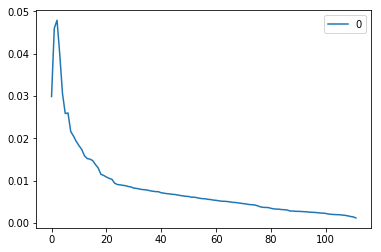

In [117]:
pd.DataFrame(svd.explained_variance_).plot()

In [114]:
# for the top 10 components, print out the top 10 lemmas that make up each component 
comp_df = pd.DataFrame(svd.components_, columns=vectorizer.get_feature_names())
for i in range(10):
    print('Component {}:\n {}\n'.format(i,comp_df.iloc[i].sort_values(ascending=False)[:10]))

Component 0:
 whale      0.418823
ahab       0.237918
ship       0.196321
ye         0.153166
thou       0.149230
captain    0.146746
boat       0.130844
syme       0.124313
thee       0.110035
stubb      0.109142
Name: 0, dtype: float64

Component 1:
 syme         0.499301
anne         0.237729
mrs          0.153786
elliot       0.147307
professor    0.138814
gregory      0.135124
wentworth    0.095746
lady         0.085715
charles      0.084928
louisa       0.082219
Name: 1, dtype: float64

Component 2:
 anne         0.402980
elliot       0.251585
mrs          0.244615
wentworth    0.169203
captain      0.150750
charles      0.147195
musgrove     0.139707
russell      0.132830
mary         0.125773
lady         0.121187
Name: 2, dtype: float64

Component 3:
 thee      0.160144
song      0.144689
thy       0.144080
thou      0.139110
city      0.135670
macb      0.103898
war       0.090611
poem      0.086646
states    0.085110
haue      0.076179
Name: 3, dtype: float64

Component 4:
 

Component Notes:
- Component 0:
    - seems to be related to Moby Dick
    - seafaring words
    - 2nd word, 'ahab', is the main character of Moby Dick
- Component 1:
    - names and titles mostly from Persuasion
- Component 2
    - names and titles mostly from Persuasion
- Component 3
    - some shakespearian english words
    - probably related to macbeth
- Component 4
    - similar to Component 3
- Component 5
    - seems to be related to alice and wonderland
- Component 6
    - similar to component 5
    - animal words
- Component 7
    - combination of whale words (Moby Dick) and macbeth words
- Component 8
    - mostly names, unsure of which author they're from
    - keys in on Edgeworth and Austen based on texts with highest component 8 value (below)
- Component 9
    - mostly names, unsure of which author most are from
    - keys in on Edgeworth based on texts with highest component 9 value (below)

In [123]:
lsa_df = pd.DataFrame(train_lsa)
lsa_df['author'] = train_df['author']

In [125]:
lsa_df.sort_values(by=8, ascending=False)[[8, 'author']][:10]

,8,author
77,0.495245,Edgeworth
18,0.464628,Edgeworth
73,0.460690,Edgeworth
102,0.290706,Edgeworth
46,0.104827,Blake
52,0.090042,Austen
81,0.087961,Austen
101,0.087279,Austen
20,0.079011,Austen
61,0.078918,Austen


In [126]:
lsa_df.sort_values(by=9, ascending=False)[[9, 'author']][:10]

,9,author
75,0.628032,Edgeworth
57,0.627512,Edgeworth
27,0.582769,Edgeworth
65,0.202646,Edgeworth
108,0.141459,Edgeworth
72,0.134996,Edgeworth
102,0.085627,Edgeworth
81,0.053962,Austen
77,0.051364,Edgeworth
52,0.042459,Austen


## Kmeans

### 2

In [128]:
for _ in range(4):
    n_clusters = 2
    km = KMeans(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1
author             
Austen        0   8
Blake         0   3
Bryant        0   8
Burgess       0   2
Carroll       0   5
Chesterton   11   0
Edgeworth     0  26
Melville      0  24
Shakespeare   0   5
Whitman       0  20 

cluster       0   1
author             
Austen        0   8
Blake         0   3
Bryant        0   8
Burgess       0   2
Carroll       0   5
Chesterton   11   0
Edgeworth     0  26
Melville      0  24
Shakespeare   0   5
Whitman       0  20 

cluster       0   1
author             
Austen        0   8
Blake         3   0
Bryant        8   0
Burgess       2   0
Carroll       5   0
Chesterton   11   0
Edgeworth    26   0
Melville      0  24
Shakespeare   5   0
Whitman      20   0 

cluster       0   1
author             
Austen        8   0
Blake         3   0
Bryant        8   0
Burgess       2   0
Carroll       5   0
Chesterton   11   0
Edgeworth    26   0
Melville      0  24
Shakespeare   5   0
Whitman      20   0 



In [206]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters)
km.fit(train_lsa)

train_df['cluster'] = km.labels_

print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1
author             
Austen        0   8
Blake         0   3
Bryant        0   8
Burgess       0   2
Carroll       0   5
Chesterton    0  11
Edgeworth     0  26
Melville     24   0
Shakespeare   0   5
Whitman       0  20 



In [210]:
train_lsa[train_df['cluster']==1].shape, train_lsa.shape

((88, 112), (112, 112))

In [217]:
km2.labels_.shape

(88,)

In [216]:
train_df[train_df['cluster']==1]['cluster']

1      1
2      1
3      1
4      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
23     1
24     1
25     1
27     1
28     1
29     1
31     1
32     1
34     1
35     1
      ..
75     1
76     1
77     1
78     1
79     1
81     1
82     1
83     1
85     1
86     1
88     1
89     1
90     1
92     1
93     1
94     1
95     1
97     1
98     1
99     1
100    1
101    1
102    1
103    1
104    1
106    1
107    1
108    1
109    1
110    1
Name: cluster, Length: 88, dtype: int32

In [211]:
n_clusters = 2
km2 = KMeans(n_clusters=n_clusters)
km2.fit(train_lsa[train_df['cluster']==1])

c:\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


cluster       0   1
author             
Austen        0   8
Blake         0   3
Bryant        0   8
Burgess       0   2
Carroll       0   5
Chesterton    0  11
Edgeworth     0  26
Melville     24   0
Shakespeare   0   5
Whitman       0  20 



In [227]:
c = 0 
for i, cluster in enumerate(train_df['cluster']):   
    if cluster != 0:
        train_df['cluster'][i] = km2.labels_[c]+1
        c += 1

c:\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [228]:
print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1   2
author                 
Austen        0   0   8
Blake         0   0   3
Bryant        0   0   8
Burgess       0   0   2
Carroll       0   0   5
Chesterton    0  11   0
Edgeworth     0   0  26
Melville     24   0   0
Shakespeare   0   0   5
Whitman       0   0  20 



In [229]:
n_clusters = 2
km2 = KMeans(n_clusters=n_clusters)
km2.fit(train_lsa[train_df['cluster']==2])

c = 0 
for i, cluster in enumerate(train_df['cluster']):   
    if cluster == 2:
        train_df['cluster'][i] = km2.labels_[c]+2
        c += 1

print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

c:\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


cluster       0   1   2   3
author                     
Austen        0   0   8   0
Blake         0   0   0   3
Bryant        0   0   6   2
Burgess       0   0   2   0
Carroll       0   0   5   0
Chesterton    0  11   0   0
Edgeworth     0   0  26   0
Melville     24   0   0   0
Shakespeare   0   0   0   5
Whitman       0   0   0  20 



Notes:

- First 3 clustering attempts:
    - one cluster made up entirely of Melville, or mostly of Melville plus one other author
    - other cluster made up of remaining authors
    - No authors split between clusters
    
- Last cluster attempt:
    - one cluster all Chesterton, other cluster remaining
    - No authors split between clusters

#### Samples

In [161]:
n_rows = len(train_lsa)
n_samples = 2

indexes = np.arange(n_rows)
sample_indexes = np.random.choice(indexes, size=(n_samples, n_rows//n_samples), replace=False)

samples = [train_lsa[sample_indexes[i]] for i in range(n_samples)]

In [163]:
n_clusters = 2
for i, sample in enumerate(samples):
    km = KMeans(n_clusters=n_clusters)
    km.fit(sample)
    
    print(pd.crosstab(train_df.iloc[sample_indexes[i]]['author'], km.labels_), '\n')

col_0         0  1
author            
Austen        1  0
Blake         2  0
Bryant        2  0
Carroll       2  0
Chesterton    0  7
Edgeworth    18  0
Melville     11  0
Shakespeare   5  0
Whitman       8  0 

col_0       0   1
author           
Austen      7   0
Blake       0   1
Bryant      0   6
Burgess     0   2
Carroll     0   3
Chesterton  0   4
Edgeworth   8   0
Melville    0  13
Whitman     0  12 



### 5

In [73]:
for _ in range(4):
    n_clusters = 5
    km = KMeans(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1   2   3  4
author                        
Austen        0   8   0   0  0
Blake         0   0   3   0  0
Bryant        0   0   8   0  0
Burgess       0   0   2   0  0
Carroll       0   0   5   0  0
Chesterton   11   0   0   0  0
Edgeworth     0  19   7   0  0
Melville      0   0   1  23  0
Shakespeare   0   0   0   0  5
Whitman       0   0  20   0  0 

cluster       0   1   2   3   4
author                         
Austen        0   8   0   0   0
Blake         0   0   0   3   0
Bryant        0   4   0   4   0
Burgess       0   2   0   0   0
Carroll       0   5   0   0   0
Chesterton    0   0   0   0  11
Edgeworth    14  12   0   0   0
Melville      0   2  22   0   0
Shakespeare   0   0   0   5   0
Whitman       0   0   0  20   0 

cluster       0   1   2   3  4
author                        
Austen        8   0   0   0  0
Blake         0   0   0   3  0
Bryant        1   0   0   6  1
Burgess       1   0   0   0  1
Carroll       0   0   0   0  5
Chesterton    0  11   0

In [173]:
for _ in range(4):
    n_clusters = 5
    km = KMeans(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1   2   3   4
author                         
Austen        8   0   0   0   0
Blake         0   0   0   0   3
Bryant        0   0   3   0   5
Burgess       0   0   2   0   0
Carroll       0   0   5   0   0
Chesterton    0  11   0   0   0
Edgeworth    15   0  11   0   0
Melville      0   0   5  19   0
Shakespeare   0   0   0   0   5
Whitman       0   0   0   0  20 

cluster       0   1   2  3   4
author                        
Austen        0   8   0  0   0
Blake         0   0   0  2   1
Bryant        0   0   0  5   3
Burgess       0   0   0  0   2
Carroll       0   0   0  5   0
Chesterton   11   0   0  0   0
Edgeworth     0  15   0  4   7
Melville      0   5  19  0   0
Shakespeare   0   0   0  5   0
Whitman       0   0   0  0  20 

cluster       0   1  2   3   4
author                        
Austen        0   0  8   0   0
Blake         0   3  0   0   0
Bryant        0   8  0   0   0
Burgess       0   2  0   0   0
Carroll       0   3  0   0   2
Chesterton    0   0  0 

Notes:

- Chesterton always got own cluster (and not split between clusters)
- Authors split between clusters: Edgeworth(4/4), Bryant(2/4), Melvin (2/4), Blake(1/4), Carrol(1/4)
- Authors never split between clusters: Austen, Chesterton, Shakespeare, Whitman, Burgess
- Groups often in same cluster:
    - Blake, Bryant, Whitman (4)
    - Shakespeare, Blake, Bryant (3)
    - Shakespeare, Whitman (3)
    - Blake, Bryant, Burgess, Whitman (3)
    - Austen, Edgeworth (3)
    

### 10

In [175]:
for _ in range(4):
    n_clusters = 10
    km = KMeans(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster       0   1   2  3   4   5  6  7  8  9
author                                        
Austen        0   0   0  0   0   0  0  8  0  0
Blake         0   0   0  0   0   3  0  0  0  0
Bryant        2   0   0  0   0   4  1  0  0  1
Burgess       0   0   0  0   0   0  0  0  0  2
Carroll       0   0   0  0   0   0  5  0  0  0
Chesterton    0   0  11  0   0   0  0  0  0  0
Edgeworth    14   0   0  0   0   0  0  3  9  0
Melville      0  12   0  0  12   0  0  0  0  0
Shakespeare   0   0   0  5   0   0  0  0  0  0
Whitman       0   0   0  0   0  20  0  0  0  0 

cluster      0   1   2   3  4  5  6   7   8  9
author                                        
Austen       0   0   0   0  0  8  0   0   0  0
Blake        0   0   0   3  0  0  0   0   0  0
Bryant       0   0   0   7  0  0  1   0   0  0
Burgess      0   0   0   0  0  0  0   0   2  0
Carroll      0   0   0   0  0  0  5   0   0  0
Chesterton   0   0  11   0  0  0  0   0   0  0
Edgeworth    6   0   0   0  5  5  0   0  10  0
Melville   

Notes:

- All Chesterton always in exclusive cluster
- All Shakespeare always in exclusive cluster
- Melville always in 2 exclusive clusters
- Interesting groupings:
    - Blake, Bryant, Whitman (4)
    - Austen, Edgeworth (4)

### 20

In [176]:
for _ in range(4):
    n_clusters = 20
    km = KMeans(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

cluster      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
author                                                                        
Austen        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8   
Blake         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Bryant        0   0   0   0   0   0   0   1   1   0   0   1   0   4   0   0   
Burgess       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Carroll       0   0   0   0   0   0   0   0   5   0   0   0   0   0   0   0   
Chesterton    0  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Edgeworth     0   0   0   5   0   4   0   0   0   4   4   2   0   1   4   0   
Melville      9   0   0   0   3   0   0   0   0   0   0   0  10   0   0   0   
Shakespeare   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   
Whitman       0   0   0   0   0   0   3  17   0   0   0   0   0   0   0   0   

cluster      16  17  18  19  
author               

Notes:

- 

## Spectral

### 2

In [180]:
for _ in range(4):
    n_clusters = 2
    km = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1
author             
Austen        8   0
Blake         3   0
Bryant        8   0
Burgess       2   0
Carroll       5   0
Chesterton   11   0
Edgeworth    26   0
Melville      2  22
Shakespeare   5   0
Whitman      20   0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1
author             
Austen        0   8
Blake         0   3
Bryant        0   8
Burgess       0   2
Carroll       0   5
Chesterton    0  11
Edgeworth     0  26
Melville     22   2
Shakespeare   0   5
Whitman       0  20 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1
author             
Austen        8   0
Blake         3   0
Bryant        8   0
Burgess       2   0
Carroll       5   0
Chesterton   11   0
Edgeworth    26   0
Melville      2  22
Shakespeare   5   0
Whitman      20   0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1
author             
Austen        8   0
Blake         3   0
Bryant        8   0
Burgess       2   0
Carroll       5   0
Chesterton   11   0
Edgeworth    26   0
Melville      2  22
Shakespeare   5   0
Whitman      20   0 



Notes:

- one cluster made up mostly or entirely of Melville, Other cluster = everything else
- Melville split into 22 and 2


### 5

In [182]:
for _ in range(4):
    n_clusters = 5
    km = SpectralClustering(n_clusters=n_clusters)
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1   2  3  4
author                       
Austen        0   0   0  0  8
Blake         3   0   0  0  0
Bryant        8   0   0  0  0
Burgess       2   0   0  0  0
Carroll       5   0   0  0  0
Chesterton    0   0  11  0  0
Edgeworth    26   0   0  0  0
Melville      2  22   0  0  0
Shakespeare   0   0   0  5  0
Whitman      20   0   0  0  0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1   2  3  4
author                       
Austen        0   0   0  0  8
Blake         3   0   0  0  0
Bryant        8   0   0  0  0
Burgess       2   0   0  0  0
Carroll       5   0   0  0  0
Chesterton    0  11   0  0  0
Edgeworth    26   0   0  0  0
Melville      2   0  22  0  0
Shakespeare   0   0   0  5  0
Whitman      20   0   0  0  0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1  2   3  4
author                       
Austen        0   0  0   0  8
Blake         0   3  0   0  0
Bryant        0   8  0   0  0
Burgess       0   2  0   0  0
Carroll       0   5  0   0  0
Chesterton    0   0  0  11  0
Edgeworth     0  26  0   0  0
Melville     22   2  0   0  0
Shakespeare   0   0  5   0  0
Whitman       0  20  0   0  0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0   1   2  3  4
author                       
Austen        0   0   0  0  8
Blake         3   0   0  0  0
Bryant        8   0   0  0  0
Burgess       2   0   0  0  0
Carroll       5   0   0  0  0
Chesterton    0  11   0  0  0
Edgeworth    26   0   0  0  0
Melville      2   0  22  0  0
Shakespeare   0   0   0  5  0
Whitman      20   0   0  0  0 



Notes:

- All Austen always in exclusive cluster
- All Shakespeare always in exclusive cluster
- All Chesterton always in exclusive cluster
- 22/24 Melville always in exclusive cluster

### 10

In [183]:
for _ in range(4):
    n_clusters = 10
    km = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2  3  4   5  6  7   8   9
author                                        
Austen       0   0   0  0  8   0  0  0   0   0
Blake        0   0   0  0  0   0  0  0   0   3
Bryant       0   0   8  0  0   0  0  0   0   0
Burgess      0   0   2  0  0   0  0  0   0   0
Carroll      5   0   0  0  0   0  0  0   0   0
Chesterton   0  11   0  0  0   0  0  0   0   0
Edgeworth    0   0  19  4  0   0  3  0   0   0
Melville     0   0   2  0  0  12  0  0  10   0
Shakespeare  0   0   0  0  0   0  0  5   0   0
Whitman      0   0   0  0  0   0  0  0   0  20 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2   3  4  5  6  7   8   9
author                                        
Austen       0   0   0   0  8  0  0  0   0   0
Blake        0   0   0   0  0  0  0  0   0   3
Bryant       0   0   8   0  0  0  0  0   0   0
Burgess      0   0   2   0  0  0  0  0   0   0
Carroll      5   0   0   0  0  0  0  0   0   0
Chesterton   0   0   0  11  0  0  0  0   0   0
Edgeworth    0   0  19   0  0  4  3  0   0   0
Melville     0  12   2   0  0  0  0  0  10   0
Shakespeare  0   0   0   0  0  0  0  5   0   0
Whitman      0   0   0   0  0  0  0  0   0  20 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster       0  1  2   3  4   5  6   7  8   9
author                                        
Austen        0  0  0   0  0   0  0   0  8   0
Blake         0  0  0   0  0   0  0   3  0   0
Bryant        8  0  0   0  0   0  0   0  0   0
Burgess       2  0  0   0  0   0  0   0  0   0
Carroll       0  5  0   0  0   0  0   0  0   0
Chesterton    0  0  0  11  0   0  0   0  0   0
Edgeworth    19  0  0   0  3   0  4   0  0   0
Melville      2  0  0   0  0  12  0   0  0  10
Shakespeare   0  0  5   0  0   0  0   0  0   0
Whitman       0  0  0   0  0   0  0  20  0   0 



c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1  2  3  4   5   6  7   8   9
author                                        
Austen       0   0  0  8  0   0   0  0   0   0
Blake        0   0  0  0  0   0   0  0   3   0
Bryant       0   8  0  0  0   0   0  0   0   0
Burgess      0   2  0  0  0   0   0  0   0   0
Carroll      0   0  5  0  0   0   0  0   0   0
Chesterton   0   0  0  0  0  11   0  0   0   0
Edgeworth    4  19  0  0  0   0   0  3   0   0
Melville     0   2  0  0  0   0  12  0   0  10
Shakespeare  0   0  0  0  5   0   0  0   0   0
Whitman      0   0  0  0  0   0   0  0  20   0 



Notes

- Pretty good:
    - 58/112 texts in exclusive clusters
- Edgeworth always split
- Melville always split, but most end up in exclusive clusters
- Blake and Whitman always in same cluster
- Bryant, Burgess, and most of Edgeworth always in same cluster

#### Samples

In [186]:
n_rows = len(train_lsa)
n_samples = 2

indexes = np.arange(n_rows)
sample_indexes = np.random.choice(indexes, size=(n_samples, n_rows//n_samples), replace=False)

samples = [train_lsa[sample_indexes[i]] for i in range(n_samples)]

In [187]:
n_clusters = 10
for i, sample in enumerate(samples):
    km = SpectralClustering(n_clusters=n_clusters)
    km.fit(sample)
    
    print(pd.crosstab(train_df.iloc[sample_indexes[i]]['author'], km.labels_), '\n')

col_0        0   1  2  3  4  5  6  7  8  9
author                                    
Austen       0   0  0  0  0  0  0  0  0  3
Blake        1   0  0  0  0  0  0  0  0  0
Bryant       5   0  0  0  0  0  0  0  0  0
Burgess      1   0  0  0  0  0  0  0  0  0
Carroll      0   0  0  0  0  0  5  0  0  0
Chesterton   0   0  0  6  0  0  0  0  0  0
Edgeworth    7   0  2  0  0  0  0  0  2  0
Melville     1   0  0  0  4  4  0  0  0  0
Shakespeare  0   0  0  0  0  0  0  4  0  0
Whitman      0  11  0  0  0  0  0  0  0  0 

col_0        0  1  2  3  4  5  6  7  8  9
author                                   
Austen       0  0  0  0  0  0  5  0  0  0
Blake        0  2  0  0  0  0  0  0  0  0
Bryant       0  3  0  0  0  0  0  0  0  0
Burgess      0  1  0  0  0  0  0  0  0  0
Chesterton   0  0  5  0  0  0  0  0  0  0
Edgeworth    2  5  0  2  2  2  0  0  2  0
Melville     0  1  0  0  0  0  0  7  0  7
Shakespeare  0  1  0  0  0  0  0  0  0  0
Whitman      0  9  0  0  0  0  0  0  0  0 



### 20

In [184]:
for _ in range(4):
    n_clusters = 20
    km = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
author                                                                        
Austen        0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   
Blake         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Bryant        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Burgess       0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   
Carroll       0   0   0   0   0   0   0   0   0   0   5   0   0   0   0   0   
Chesterton    0   0   0   0   0   8   0   0   0   0   0   0   0   0   0   0   
Edgeworth     0   0   3   0   0   0   0   0   3   2   0   0   2   4   2   2   
Melville      0   0   0   0   8   0  11   0   0   0   0   3   0   0   0   0   
Shakespeare   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Whitman      20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

cluster      16  17  18  19  
author               

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
author                                                                        
Austen        0   0   0   0   0   0   0   0   0   0   0   8   0   0   0   0   
Blake         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Bryant        0   0   0   0   0   8   0   0   0   0   0   0   0   0   0   0   
Burgess       0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   
Carroll       0   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   
Chesterton    0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   0   
Edgeworth     0   2   0   0   2   6   0   0   4   2   0   0   3   2   3   2   
Melville     11   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   
Shakespeare   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   
Whitman       0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   

cluster      16  17  18  19  
author               

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
author                                                                        
Austen        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Blake         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Bryant        0   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Burgess       0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   
Carroll       5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Chesterton    0   0   3   0   0   0   0   0   0   0   0   0   0   0   8   0   
Edgeworth     0   6   0   0   2   2   2   0   3   3   4   0   2   0   0   0   
Melville      0   2   0   0   0   0   0   0   0   0   0   0   0   8   0  11   
Shakespeare   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0   
Whitman       0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   

cluster      16  17  18  19  
author               

c:\python37\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
author                                                                        
Austen        0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   
Blake         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Bryant        0   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
Burgess       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   
Carroll       0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   
Chesterton    0   0   0   8   0   0   0   0   0   0   0   0   0   3   0   0   
Edgeworth     3   6   0   0   4   0   2   0   0   2   3   2   2   0   0   0   
Melville      0   2   0   0   0   0   0   0   8   0   0   0   0   0   0   0   
Shakespeare   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   
Whitman       0   0   0   0   0   0   0   0   0   0   0   0   0   0  20   0   

cluster      16  17  18  19  
author               

Notes:

- 98/112 texts in exclusive clusters

## Mean-Shift

In [259]:
for _ in range(4):
    km = MeanShift()
    km.fit(train_lsa)

    train_df['cluster'] = km.labels_

    print(pd.crosstab(train_df['author'], train_df['cluster']), '\n')

AttributeError: module 'numpy.random' has no attribute 'bin_seeding'

In [129]:
max(km.labels_)

0

## Affinity Propagation

In [75]:
pd.options.display.max_columns = 30

In [173]:
km = AffinityPropagation()
km.fit(train_lsa)

train_df['cluster'] = km.labels_

cluster_df = pd.crosstab(train_df['author'], train_df['cluster'])
cluster_df

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
author,,,,,,,,,,,,,,,,,,,,,
Austen,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0
Blake,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
Bryant,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4
Burgess,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Carroll,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chesterton,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,8,0
Edgeworth,0,0,4,0,0,3,0,4,0,0,2,0,0,4,0,0,2,3,4,0,0
Melville,11,0,0,0,0,0,0,0,0,4,0,0,0,0,9,0,0,0,0,0,0
Shakespeare,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
test_df['author'].value_counts()

Edgeworth      12
Whitman         5
Bryant          4
Melville        4
Carroll         4
Austen          3
Chesterton      2
Shakespeare     2
Burgess         1
Name: author, dtype: int64

In [175]:
pd.crosstab(test_df['author'], km.predict(test_lsa))

col_0,0,1,2,3,4,5,6,7,8,10,13,16,17,19,20
author,,,,,,,,,,,,,,,
Austen,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
Bryant,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2
Burgess,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Carroll,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0
Chesterton,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
Edgeworth,0,0,1,0,0,1,0,1,0,3,2,3,1,0,0
Melville,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Shakespeare,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
Whitman,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0


In [176]:
# name each cluster based on author most represented by cluster and save in dictionary
cluster_names = {}
for i in range(21):
    col = cluster_df[i]
    cluster_name = col.idxmax()

    cluster_names[i] = cluster_name
cluster_names

{0: 'Melville',
 1: 'Carroll',
 2: 'Edgeworth',
 3: 'Bryant',
 4: 'Shakespeare',
 5: 'Edgeworth',
 6: 'Burgess',
 7: 'Edgeworth',
 8: 'Whitman',
 9: 'Melville',
 10: 'Austen',
 11: 'Blake',
 12: 'Chesterton',
 13: 'Edgeworth',
 14: 'Melville',
 15: 'Whitman',
 16: 'Edgeworth',
 17: 'Edgeworth',
 18: 'Edgeworth',
 19: 'Chesterton',
 20: 'Bryant'}

In [177]:
# predict test clusters, 
test_cluster_pred = [cluster_names[i] for i in km.predict(test_lsa)]
test_df['cluster_pred'] =  test_cluster_pred
test_df['correct_pred'] = test_df['author'] == test_df['cluster_pred']

print('score: {}/{}, {}'.format(test_df.correct_pred.sum(), len(test_df), test_df.correct_pred.sum()/len(test_df)))
test_df[['author', 'cluster_pred', 'correct_pred']]

score: 34/37, 0.918918918918919


,author,cluster_pred,correct_pred
0,Austen,Austen,True
1,Austen,Austen,True
2,Austen,Austen,True
3,Bryant,Bryant,True
4,Bryant,Bryant,True
5,Bryant,Bryant,True
6,Bryant,Bryant,True
7,Burgess,Burgess,True
8,Carroll,Carroll,True
9,Carroll,Carroll,True


# Bag of Words + Naive Bayes

In [460]:
# fit and score NB just with bag of words counts
nb = MultinomialNB()

X = train_counts_matrix
y = train_df['author']

nb.fit(X, y)
print('Training score: ', nb.score(X, y))
print('Testing score: ', nb.score(test_counts_matrix, test_df['author']))

1.0
1.0


In [178]:

# Turn Bag of Words process into a class with fit and transform methods so we can use it in a pipeline
# sklearn CountVectorizer does what we want (counts word occurences) 
# but the fit method in this class gets us the top n_words per author to pass to CountVectorizer
class CountWords():
    def __init__(self, n_words=1000):      
        self.n_words = n_words
        self.words = []
        
    def fit(self, texts, authors):
        texts = list(texts)
        
        # get top n_words from each author using Count
        for author in set(authors):
            author_indices = [i for i, auth in enumerate(authors) if auth == author]
            author_text = [texts[index] for index in author_indices]
            cv = CountVectorizer(stop_words='english', lowercase=True, max_features=self.n_words)
            cv.fit(author_text)        
            self.words += cv.get_feature_names()
        self.words = list(set(self.words))
        
    def transform(self, texts, authors=None):
        cv = CountVectorizer(stop_words='english', lowercase=True, vocabulary=self.words)
        return cv.transform(texts)
    
    def fit_transform(self, texts, authors):
        self.fit(texts, authors)
        return self.transform(texts, authors)
    

In [268]:
# with our CountWords class we can create a bag of words pipeline and use it in cross validation
bow_nb = make_pipeline(CountWords(n_words=200), MultinomialNB())

# words will now be baggged based on the training set in each fold of cross validation.

cv = cross_val_score(bow_nb, df['lemmas'], df['author'], cv=3)
print('cross val scores: ', cv)

cross val scores:  [1.         1.         0.95744681]
